##  scCODA - Compositional analysis of labeled single-cell data

In [20]:
import warnings
warnings.filterwarnings("ignore")

import mudata as mu
import matplotlib.pyplot as plt
import scanpy as sc
import pertpy as pt
plt.rcParams['figure.figsize'] = (10, 10)

In [9]:
# path of partly preprocessed HLCA file used in this notebook:
adata_path = "/home/h/hollenberg/MaPra/adata_annotated.h5ad"
#adata_path = "/home/h/hollenberg/MaPra/adata_processed_2_lea.h5ad"

# path to results directory:
dir_out = "/home/h/hollenberg/MaPra/"

In [13]:
adata = sc.read(adata_path)
adata = adata[adata.obs.condition != "nintedanib"]
adata

View of AnnData object with n_obs × n_vars = 12648 × 18252
    obs: 'samples', 'GSM', 'condition', 'id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'n_counts', 'doublet_score', 'predicted_doublet', 'is_doublet', 'leiden', 'manual_celltype_annotation_coarse', 'manual_celltype_annotation_precise'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    uns: 'condition_colors', 'is_doublet_colors', 'leiden', 'leiden_colors', 'manual_celltype_annotation_coarse_colors', 'manual_celltype_annotation_precise_colors', 'neighbors', 'pca', 'predicted_doublet_colors', 'samples_colors', 'scrublet', 'u

In [14]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(adata, type="cell_level", generate_sample_level=True, 
                                cell_type_identifier="manual_celltype_annotation_precise",
                                sample_identifier="samples", covariate_obs=["condition"])
print(sccoda_data)
print(sccoda_data["coda"].X)
print(sccoda_data["coda"].obs)

MuData object with n_obs × n_vars = 12656 × 18269
  2 modalities
    rna:	12648 x 18252
      obs:	'samples', 'GSM', 'condition', 'id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'n_counts', 'doublet_score', 'predicted_doublet', 'is_doublet', 'leiden', 'manual_celltype_annotation_coarse', 'manual_celltype_annotation_precise', 'scCODA_sample_id'
      var:	'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
      uns:	'condition_colors', 'is_doublet_colors', 'leiden', 'leiden_colors', 'manual_celltype_annotation_coarse_colors', 'manual_celltype_annotation_precise_colors', 'neighbors', 'pca', 'pred

In [15]:
# Select control and salmonella data
sccoda_data.mod["bleomycin_saline"] = sccoda_data["coda"][sccoda_data["coda"].obs["condition"].isin(["bleomycin", "saline"])].copy()
print(sccoda_data["bleomycin_saline"])

AnnData object with n_obs × n_vars = 8 × 17
    obs: 'condition', 'samples'
    var: 'n_cells'


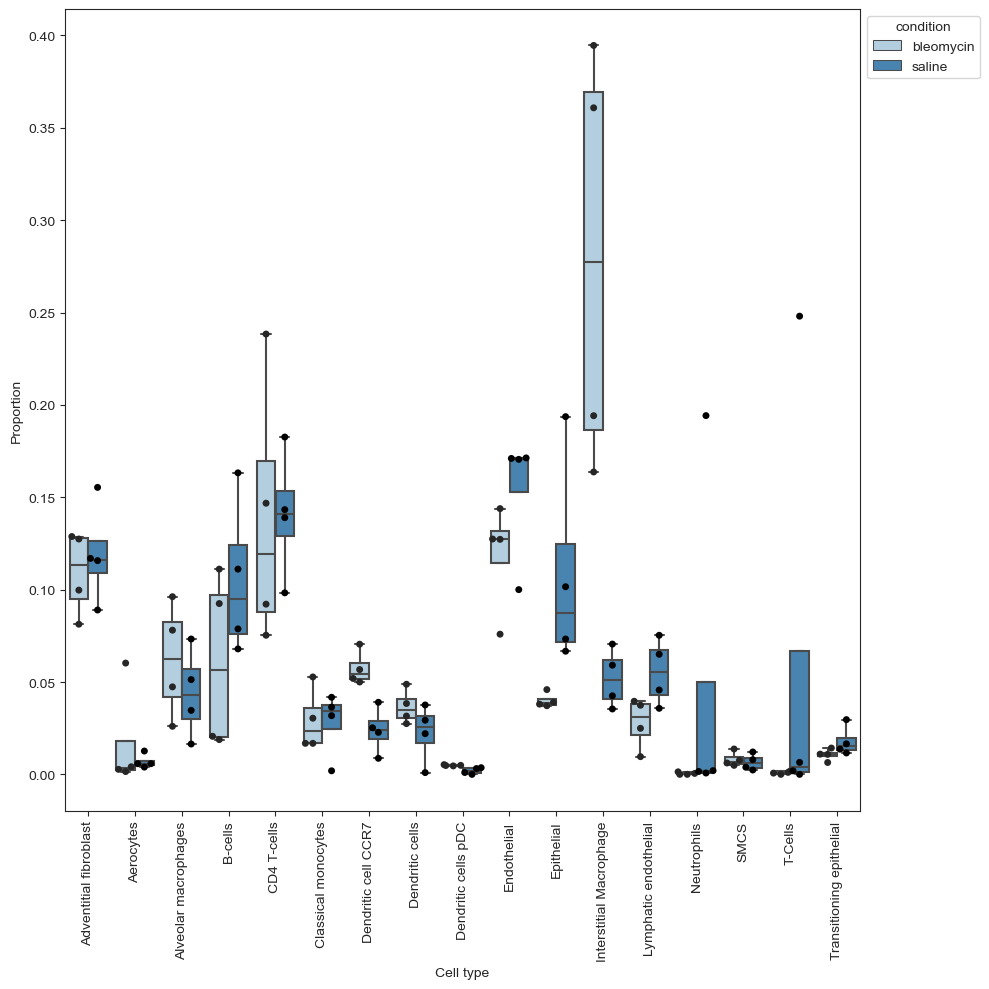

In [21]:
pt.pl.coda.boxplots(sccoda_data, modality_key="bleomycin_saline", feature_name="condition", add_dots=True)
plt.show()

In [22]:
sccoda_data = sccoda_model.prepare(sccoda_data, modality_key="bleomycin_saline", formula="condition", reference_cell_type="automatic")
sccoda_data["bleomycin_saline"]

Automatic reference selection! Reference cell type set to SMCS

Zero counts encountered in data! Added a pseudocount of 0.5.

AnnData object with n_obs × n_vars = 8 × 17
    obs: 'condition', 'samples'
    var: 'n_cells'
    uns: 'scCODA_params'
    obsm: 'covariate_matrix', 'sample_counts'

In [24]:
# Run MCMC
sccoda_model.run_nuts(sccoda_data, modality_key="bleomycin_saline")
sccoda_data["bleomycin_saline"]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
sample: 100%|█| 11000/11000 [01:09<00:00, 158.72it/s, 127 steps of size 2.63e-02


AnnData object with n_obs × n_vars = 8 × 17
    obs: 'condition', 'samples'
    var: 'n_cells'
    uns: 'scCODA_params'
    obsm: 'covariate_matrix', 'sample_counts'
    varm: 'intercept_df', 'effect_df_condition[T.saline]'

In [25]:
sccoda_model.summary(sccoda_data, modality_key="bleomycin_saline")

                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 8 samples, 17 cell types                                    │
│ Reference cell type                         │ SMCS                                                              │
│ Formula                                     │ condition                                                         │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                           Final Parameter  Expected Sample                                                      │
│ Cell Type                                                                                                       │
│ Adventitial fibroblast         1.773          172.745                                                           │
│ Aerocytes                     -0.430           19.083                                                           │
│ Alveolar macrophages           1.054           84.168                                                           │
│ B-cells                        1.179           95.375                                                           │
│ CD4 T-cells                    1.917          199.501                                                           │
│ Classical monocytes            0.422           44.738                                                           │
│ Dendritic cell CCR7            1.048           83.665                                                           │
│ Dendritic cells                0.597           53.294                                                           │
│ Dendritic cells pDC           -0.717           14.322                                                           │
│ Endothelial                    1.899          195.942                                                           │
│ Epithelial                     1.085           86.818                                                           │
│ Interstitial Macrophage        2.624          404.567                                                           │
│ Lymphatic endothelial          0.685           58.196                                                           │
│ Neutrophils                   -1.115            9.620                                                           │
│ SMCS                          -0.395           19.763                                                           │
│ T-Cells                       -1.003           10.760                                                           │
│ Transitioning epithelial      -0.020           28.755                                                           │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                             Final Parameter  Expected Sample  log2-fold change                  │
│ Covariate         Cell Type                                                                                     │
│ conditionT.saline Adventitial fibroblast         0.000          216.334             0.325                       │
│                   Aerocytes                      0.000           23.899             0.325                       │
│                   Alveolar macrophages           0.000          105.407             0.325                       │
│                   B-cells                        0.000          119.441             0.325                       │
│                   CD4 T-cells                    0.000          249.841             0.325                       │
│                   Classical monocytes            0.000           56.027             0.325                       │
│                   Dendritic cell CCR7            0.000          104.776             0.325                       │
│                   Dendritic cells                0.000           66.741             0.325                       │
│                   Dendritic cells pDC            0.000           17.936             0.325                       │
│                   Endothelial                    0.000          245.384             0.325                       │
│                   Epithelial                     0.000          108.725             0.325                       │
│                   Interstitial Macrophage       -1.549          107.636            -1.910                       │
│                   Lymphatic endothelial          0.000           72.881             0.325                       │
│                   Neutrophils                    0.000           12.047             0.325                       │
│                   SMCS                           0.000           24.750             0.325                       │
│                   T-Cells                        0.000           13.475             0.325                       │
│                   Transitioning epithelial       0.000           36.011             0.325                       │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [26]:
sccoda_model.credible_effects(sccoda_data, modality_key="bleomycin_saline")

Covariate            Cell Type               
condition[T.saline]  Adventitial fibroblast      False
                     Aerocytes                   False
                     Alveolar macrophages        False
                     B-cells                     False
                     CD4 T-cells                 False
                     Classical monocytes         False
                     Dendritic cell CCR7         False
                     Dendritic cells             False
                     Dendritic cells pDC         False
                     Endothelial                 False
                     Epithelial                  False
                     Interstitial Macrophage      True
                     Lymphatic endothelial       False
                     Neutrophils                 False
                     SMCS                        False
                     T-Cells                     False
                     Transitioning epithelial    False
Name: Final Paramet

In [31]:
sccoda_model.set_fdr(sccoda_data, modality_key="bleomycin_saline", est_fdr=0.4)
sccoda_model.summary(sccoda_data, modality_key="bleomycin_saline")

                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 8 samples, 17 cell types                                    │
│ Reference cell type                         │ SMCS                                                              │
│ Formula                                     │ condition                                                         │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                           Final Parameter  Expected Sample                                                      │
│ Cell Type                                                                                                       │
│ Adventitial fibroblast         1.773          172.745                                                           │
│ Aerocytes                     -0.430           19.083                                                           │
│ Alveolar macrophages           1.054           84.168                                                           │
│ B-cells                        1.179           95.375                                                           │
│ CD4 T-cells                    1.917          199.501                                                           │
│ Classical monocytes            0.422           44.738                                                           │
│ Dendritic cell CCR7            1.048           83.665                                                           │
│ Dendritic cells                0.597           53.294                                                           │
│ Dendritic cells pDC           -0.717           14.322                                                           │
│ Endothelial                    1.899          195.942                                                           │
│ Epithelial                     1.085           86.818                                                           │
│ Interstitial Macrophage        2.624          404.567                                                           │
│ Lymphatic endothelial          0.685           58.196                                                           │
│ Neutrophils                   -1.115            9.620                                                           │
│ SMCS                          -0.395           19.763                                                           │
│ T-Cells                       -1.003           10.760                                                           │
│ Transitioning epithelial      -0.020           28.755                                                           │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                             Final Parameter  Expected Sample  log2-fold change                  │
│ Covariate         Cell Type                                                                                     │
│ conditionT.saline Adventitial fibroblast         0.000          216.815             0.328                       │
│                   Aerocytes                      0.000           23.952             0.328                       │
│                   Alveolar macrophages          -0.387           71.758            -0.230                       │
│                   B-cells                        0.388          176.503             0.888                       │
│                   CD4 T-cells                    0.000          250.396             0.328                       │
│                   Classical monocytes           -0.267           42.999            -0.057                       │
│                   Dendritic cell CCR7           -0.756           49.290            -0.763                       │
│                   Dendritic cells               -0.615           36.154            -0.560                       │
│                   Dendritic cells pDC           -0.332           12.903            -0.151                       │
│                   Endothelial                    0.000          245.929             0.328                       │
│                   Epithelial                     0.478          175.698             1.017                       │
│                   Interstitial Macrophage       -1.549          107.875            -1.907                       │
│                   Lymphatic endothelial          0.000           73.043             0.328                       │
│                   Neutrophils                    0.377           17.610             0.872                       │
│                   SMCS                           0.000           24.805             0.328                       │
│                   T-Cells                        0.367           19.490             0.857                       │
│                   Transitioning epithelial       0.000           36.091             0.328                       │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [28]:
# saving
path = "test"
sccoda_data.write_h5mu(path)

# loading
sccoda_data_2 = mu.read_h5mu(path)

sccoda_model.summary(sccoda_data_2, modality_key="bleomycin_saline")

                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 8 samples, 17 cell types                                    │
│ Reference cell type                         │ SMCS                                                              │
│ Formula                                     │ condition                                                         │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                           Final Parameter  Expected Sample                                                      │
│ Cell Type                                                                                                       │
│ Adventitial fibroblast         1.773          172.745                                                           │
│ Aerocytes                     -0.430           19.083                                                           │
│ Alveolar macrophages           1.054           84.168                                                           │
│ B-cells                        1.179           95.375                                                           │
│ CD4 T-cells                    1.917          199.501                                                           │
│ Classical monocytes            0.422           44.738                                                           │
│ Dendritic cell CCR7            1.048           83.665                                                           │
│ Dendritic cells                0.597           53.294                                                           │
│ Dendritic cells pDC           -0.717           14.322                                                           │
│ Endothelial                    1.899          195.942                                                           │
│ Epithelial                     1.085           86.818                                                           │
│ Interstitial Macrophage        2.624          404.567                                                           │
│ Lymphatic endothelial          0.685           58.196                                                           │
│ Neutrophils                   -1.115            9.620                                                           │
│ SMCS                          -0.395           19.763                                                           │
│ T-Cells                       -1.003           10.760                                                           │
│ Transitioning epithelial      -0.020           28.755                                                           │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                                             Final Parameter  Expected Sample  log2-fold change                  │
│ Covariate         Cell Type                                                                                     │
│ conditionT.saline Adventitial fibroblast         0.000          216.334             0.325                       │
│                   Aerocytes                      0.000           23.899             0.325                       │
│                   Alveolar macrophages           0.000          105.407             0.325                       │
│                   B-cells                        0.000          119.441             0.325                       │
│                   CD4 T-cells                    0.000          249.841             0.325                       │
│                   Classical monocytes            0.000           56.027             0.325                       │
│                   Dendritic cell CCR7            0.000          104.776             0.325                       │
│                   Dendritic cells                0.000           66.741             0.325                       │
│                   Dendritic cells pDC            0.000           17.936             0.325                       │
│                   Endothelial                    0.000          245.384             0.325                       │
│                   Epithelial                     0.000          108.725             0.325                       │
│                   Interstitial Macrophage       -1.549          107.636            -1.910                       │
│                   Lymphatic endothelial          0.000           72.881             0.325                       │
│                   Neutrophils                    0.000           12.047             0.325                       │
│                   SMCS                           0.000           24.750             0.325                       │
│                   T-Cells                        0.000           13.475             0.325                       │
│                   Transitioning epithelial       0.000           36.011             0.325                       │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [32]:
test_model = pt.tl.Sccoda()
test_model.get_intercept_df(sccoda_data_2, modality_key="bleomycin_saline")
test_model.get_effect_df(sccoda_data, modality_key="bleomycin_saline")
sccoda_data["bleomycin_saline"].varm["intercept_df"]

,Final Parameter,HDI 3%,HDI 97%,SD,Expected Sample
Cell Type,,,,,
Adventitial fibroblast,1.773,1.340,2.199,0.228,172.745228
Aerocytes,-0.430,-1.135,0.227,0.368,19.083381
Alveolar macrophages,1.054,0.495,1.610,0.299,84.168255
B-cells,1.179,0.611,1.684,0.290,95.375128
CD4 T-cells,1.917,1.497,2.331,0.222,199.500718
Classical monocytes,0.422,-0.203,1.052,0.329,44.737758
Dendritic cell CCR7,1.048,0.375,1.696,0.365,83.664758
Dendritic cells,0.597,-0.112,1.327,0.385,53.293685
Dendritic cells pDC,-0.717,-1.454,0.035,0.396,14.322301
